In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [25]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

In [32]:
df.drop_duplicates(inplace=True)
df = df.dropna(subset=['bytes_in', 'bytes_out', 'creation_time', 'end_time'])
df['bytes_in'] = pd.to_numeric(df['bytes_in'], errors='coerce')
df['bytes_out'] = pd.to_numeric(df['bytes_out'], errors='coerce')
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df['session_duration_mins'] = (df['end_time'] - df['creation_time']).dt.total_seconds() / 60
df['log_bytes_in'] = np.log1p(df['bytes_in'])
df['log_bytes_out'] = np.log1p(df['bytes_out'])

## Anomaly Detection

In [33]:
features = df[['log_bytes_in', 'log_bytes_out', 'session_duration_mins']].fillna(0)

### Isolation Forest

In [36]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(features)
df['anomaly_iso'] = iso.predict(features.to_numpy())
df['anomaly_iso'] = df['anomaly_iso'].apply(lambda x: 'Anomalous' if x == -1 else 'Normal')

### Local Outlier Factor

In [38]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['anomaly_lof'] = lof.fit_predict(features)
df['anomaly_lof'] = df['anomaly_lof'].apply(lambda x: 'Anomalous' if x == -1 else 'Normal')

### Classification Model (Random Forest)

In [45]:
df['is_suspicious'] = (df['detection_types'].astype(str).str.lower().str.contains('waf')).astype(int)

X = df[['log_bytes_in', 'log_bytes_out', 'session_duration_mins']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

Confusion Matrix:
[[85]]


### Classification Model (Neural Network)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [65]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6210 - loss: 0.6900 - val_accuracy: 1.0000 - val_loss: 0.5718
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.5739 - val_accuracy: 1.0000 - val_loss: 0.4643
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.4920 - val_accuracy: 1.0000 - val_loss: 0.3725
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.4111 - val_accuracy: 1.0000 - val_loss: 0.2908
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3250 - val_accuracy: 1.0000 - val_loss: 0.2189
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2625 - val_accuracy: 1.0000 - val_loss: 0.1582
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2021 - val_accuracy: 1.0000 - val_loss: 0.1101
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1528 - val_accuracy: 1.0000 - val_loss: 0.0744


In [67]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Test Accuracy: {accuracy*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0512 
Neural Network Test Accuracy: 100.00%


In [70]:
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Neural Network Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

Confusion Matrix:
[[85]]


### Visualization

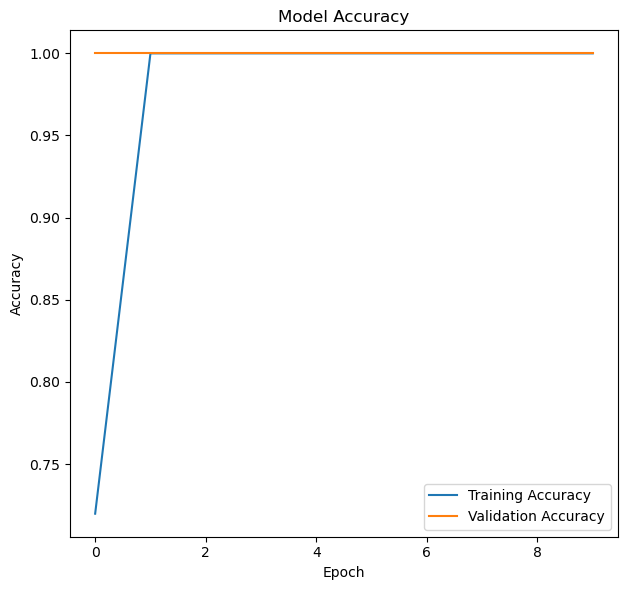

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


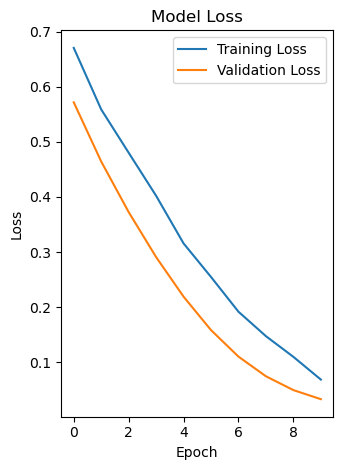

In [76]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

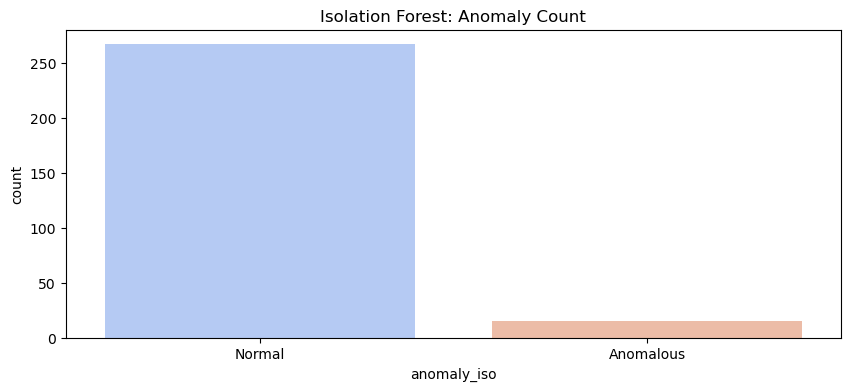

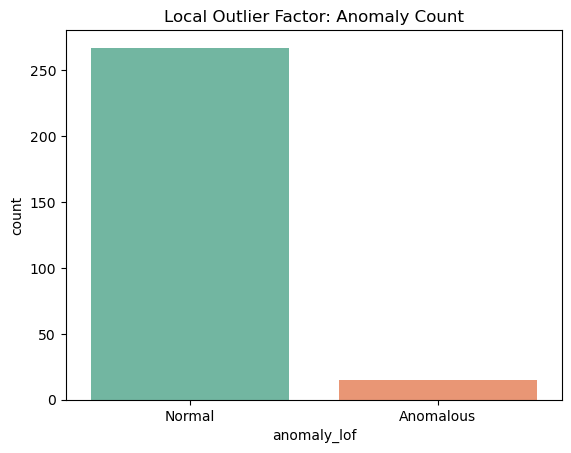

In [83]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='anomaly_iso', palette='coolwarm')
plt.title("Isolation Forest: Anomaly Count")
plt.show()

sns.countplot(data=df, x='anomaly_lof', palette='Set2')
plt.title("Local Outlier Factor: Anomaly Count")
plt.show()

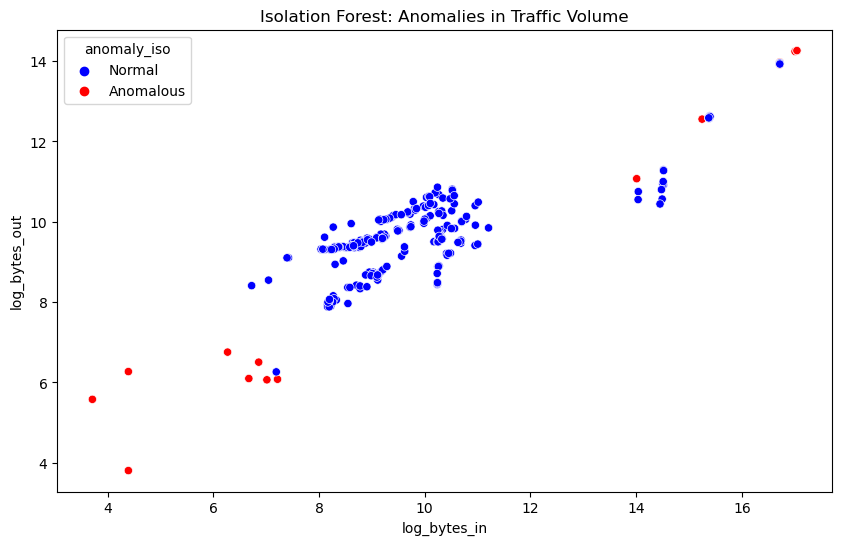

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='log_bytes_in', y='log_bytes_out', hue='anomaly_iso', palette={'Normal': 'blue', 'Anomalous': 'red'})
plt.title("Isolation Forest: Anomalies in Traffic Volume")
plt.show()

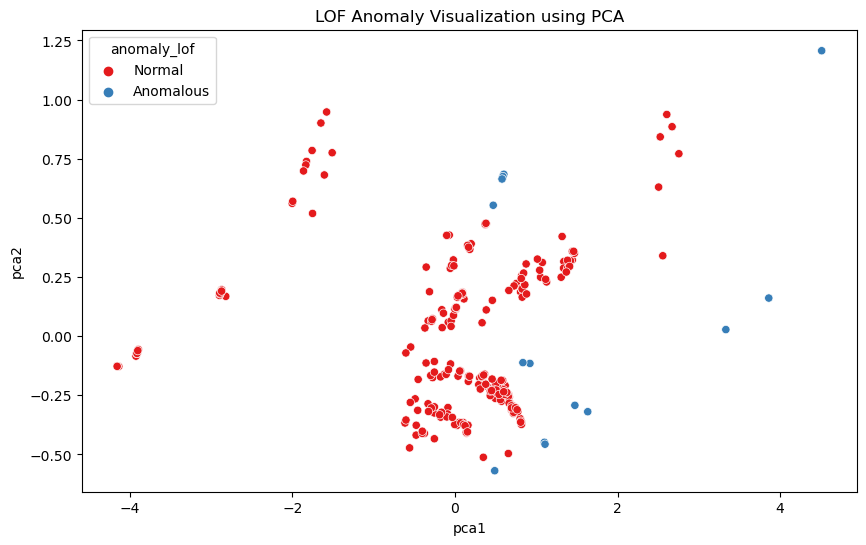

In [89]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)
df['pca1'] = pca_results[:, 0]
df['pca2'] = pca_results[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='anomaly_lof', data=df, palette='Set1')
plt.title("LOF Anomaly Visualization using PCA")
plt.show()

In [91]:
print("Top Source IPs with Anomalies (LOF):")
print(df[df['anomaly_lof'] == 'Anomalous']['src_ip'].value_counts().head(10))

Top Source IPs with Anomalies (LOF):
165.225.212.255    4
165.225.240.79     2
192.241.230.19     1
165.225.213.7      1
65.49.1.69         1
65.49.1.72         1
65.49.1.104        1
65.49.1.76         1
65.49.1.96         1
65.49.1.74         1
Name: src_ip, dtype: int64
